In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime
from tqdm import tqdm

In [2]:
ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']
data15m= pd.read_parquet(r"C:\Users\USER\Documents\Tradingstuff\rawdatabinanceBTCUSDT-15m-data.parquet",columns=ohlcv_cols)
data15m = data15m[data15m.index >= "2023-01-01"]
data = data15m.resample('1h').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'})
data.head()

,open,high,low,close,volume
timestamp,,,,,
2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399
2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826
2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668
2023-01-01 03:00:00,16542.5,16542.5,16515.0,16529.3,3214.480
2023-01-01 04:00:00,16529.2,16530.4,16508.8,16517.8,3150.954


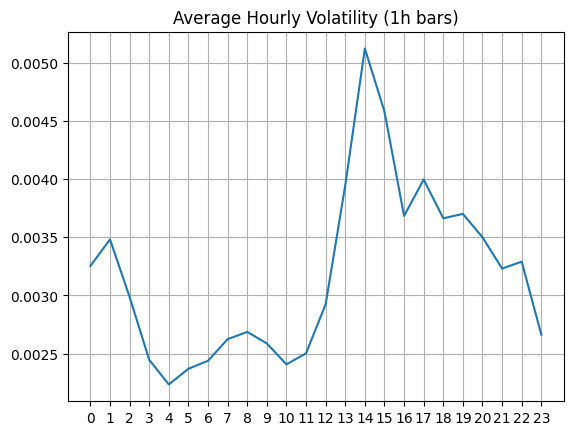

In [3]:
rets = data['close'].pct_change().dropna()
vol_arr = [np.mean(abs(ret)) for hour, ret in rets.groupby(rets.index.hour)]
plt.plot(vol_arr)
plt.xticks(range(24))
plt.grid()
plt.title("Average Hourly Volatility (1h bars)")
plt.show()


In [4]:
data1m = pd.read_parquet(r"C:\Users\USER\Documents\Binance_related\1mindata2022\BTCUSDT-1m-data.parquet", columns=ohlcv_cols)
data1m = data1m[data1m.index >= "2023-01-01"]
data1m.head()

,open,high,low,close,volume
timestamp,,,,,
2023-01-01 00:00:00,16537.5,16538.0,16534.3,16538.0,170.576
2023-01-01 00:01:00,16538.0,16538.0,16534.9,16534.9,44.287
2023-01-01 00:02:00,16534.9,16535.0,16531.3,16531.4,100.228
2023-01-01 00:03:00,16531.4,16531.4,16526.6,16526.9,317.879
2023-01-01 00:04:00,16527.0,16529.3,16523.0,16529.2,211.281


In [5]:
data1m['hour_minute'] = data1m.index.strftime('%H:%M')
rets1m = data1m['close'].pct_change().dropna()
data1m.dropna(inplace=True)


In [6]:
data1m.head()   

,open,high,low,close,volume,hour_minute
timestamp,,,,,,
2023-01-01 00:00:00,16537.5,16538.0,16534.3,16538.0,170.576,00:00
2023-01-01 00:01:00,16538.0,16538.0,16534.9,16534.9,44.287,00:01
2023-01-01 00:02:00,16534.9,16535.0,16531.3,16531.4,100.228,00:02
2023-01-01 00:03:00,16531.4,16531.4,16526.6,16526.9,317.879,00:03
2023-01-01 00:04:00,16527.0,16529.3,16523.0,16529.2,211.281,00:04


In [7]:
data30min = data1m.resample('30T').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'})
rets30min = data30min['close'].pct_change().dropna()
data30min.dropna(inplace=True)
data30min.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_6844\1535907665.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data30min = data1m.resample('30T').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'})


,open,high,low,close,volume
timestamp,,,,,
2023-01-01 00:00:00,16537.5,16540.9,16513.4,16539.4,2832.734
2023-01-01 00:30:00,16539.3,16539.4,16504.0,16527.0,2548.665
2023-01-01 01:00:00,16527.1,16539.0,16524.1,16530.1,1457.856
2023-01-01 01:30:00,16530.1,16554.3,16527.9,16550.4,1752.970
2023-01-01 02:00:00,16550.5,16552.0,16540.0,16551.9,1267.370


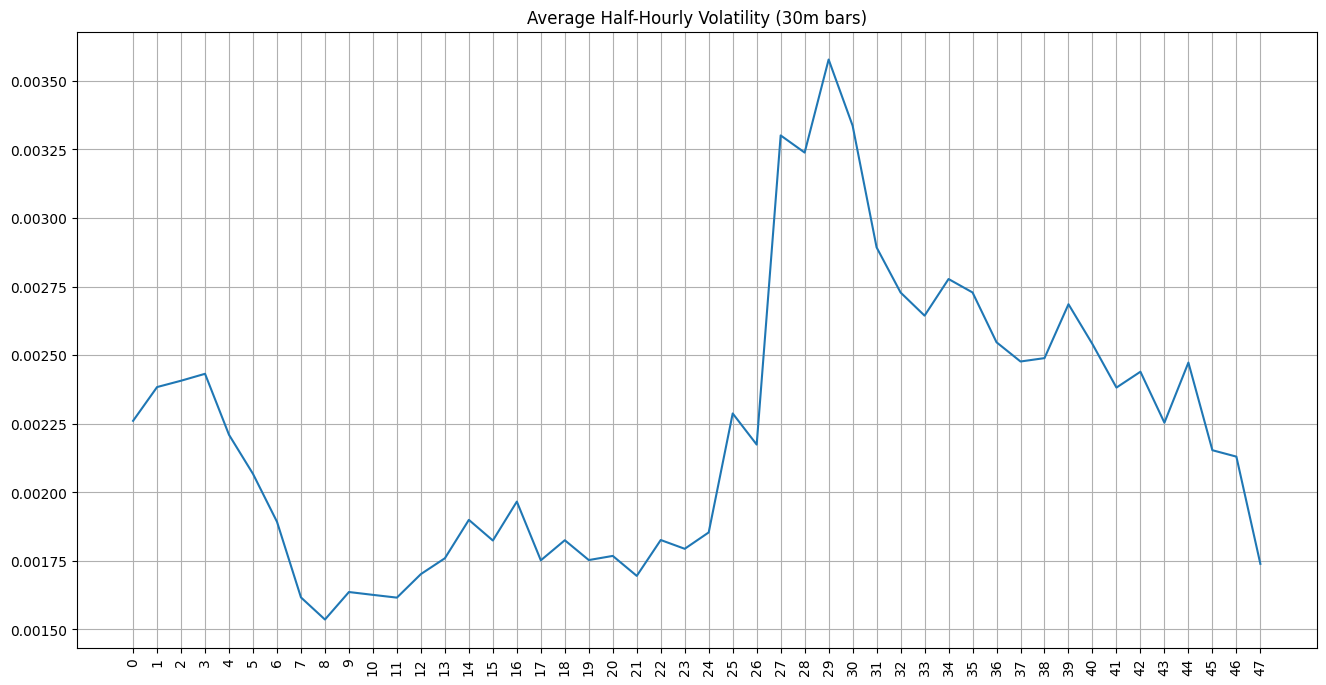

In [8]:
data30min['half_hour'] = data30min.index.strftime('%H:%M')
vol_arr_30min = [np.mean(abs(ret)) for hh, ret in rets30min.groupby(data30min['half_hour'])]
plt.figure(figsize=(16,8))
plt.plot(vol_arr_30min)
plt.xticks(range(0,48,1),rotation=90)
plt.grid()
plt.title("Average Half-Hourly Volatility (30m bars)")
plt.show()

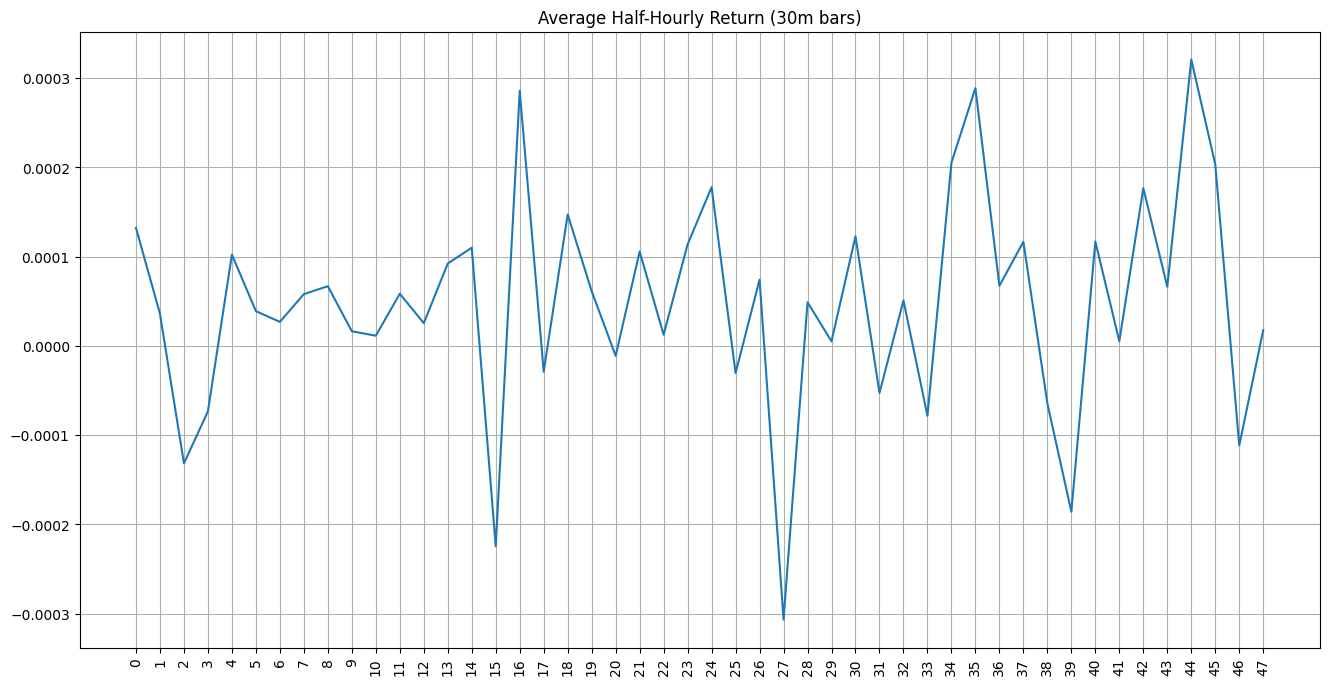

In [9]:
ret_arr_30m = [np.mean(ret) for hh, ret in rets30min.groupby(data30min['half_hour'])]
plt.figure(figsize=(16,8))
plt.plot(ret_arr_30m)
plt.xticks(range(0,48,1),rotation=90)
plt.grid()
plt.title("Average Half-Hourly Return (30m bars)")
plt.show()

Correlation between 30min volatility and return: 0.0181
Regression: return = 0.0232 * volatility + -4.6502e-06


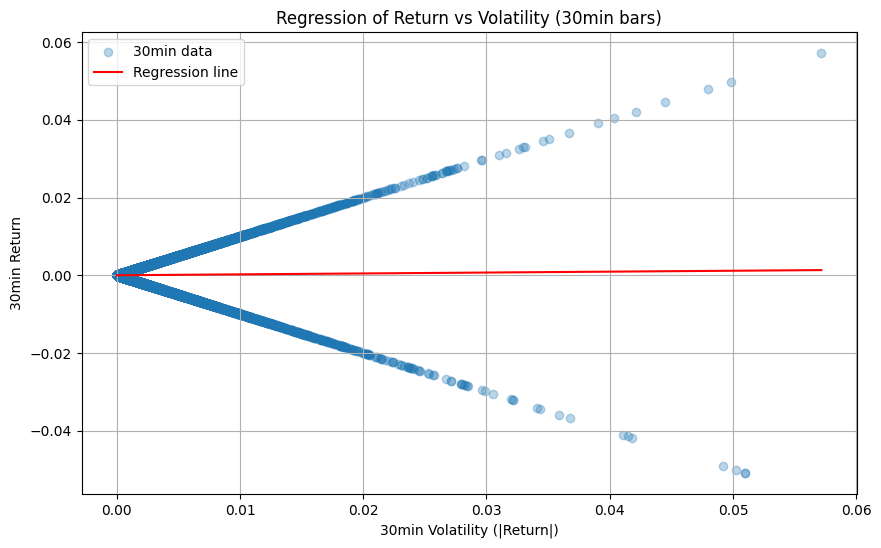

In [10]:
# Correlation and regression between volatility and return (30min data)
from scipy.stats import linregress

# Calculate volatility (absolute return) and return for each 30min slot
vol_30m = np.abs(rets30min)
ret_30m = rets30min

# Remove any NaNs (should be none after dropna, but just in case)
mask = (~np.isnan(vol_30m)) & (~np.isnan(ret_30m))
vol_30m = vol_30m[mask]
ret_30m = ret_30m[mask]

# Correlation
corr = np.corrcoef(vol_30m, ret_30m)[0,1]
print(f"Correlation between 30min volatility and return: {corr:.4f}")

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(vol_30m, ret_30m)
print(f"Regression: return = {slope:.4f} * volatility + {intercept:.4e}")

# Plot
plt.figure(figsize=(10,6))
plt.scatter(vol_30m, ret_30m, alpha=0.3, label='30min data')
x_vals = np.linspace(vol_30m.min(), vol_30m.max(), 100)
plt.plot(x_vals, slope*x_vals + intercept, color='red', label='Regression line')
plt.xlabel('30min Volatility (|Return|)')
plt.ylabel('30min Return')
plt.title('Regression of Return vs Volatility (30min bars)')
plt.legend()
plt.grid()
plt.show()

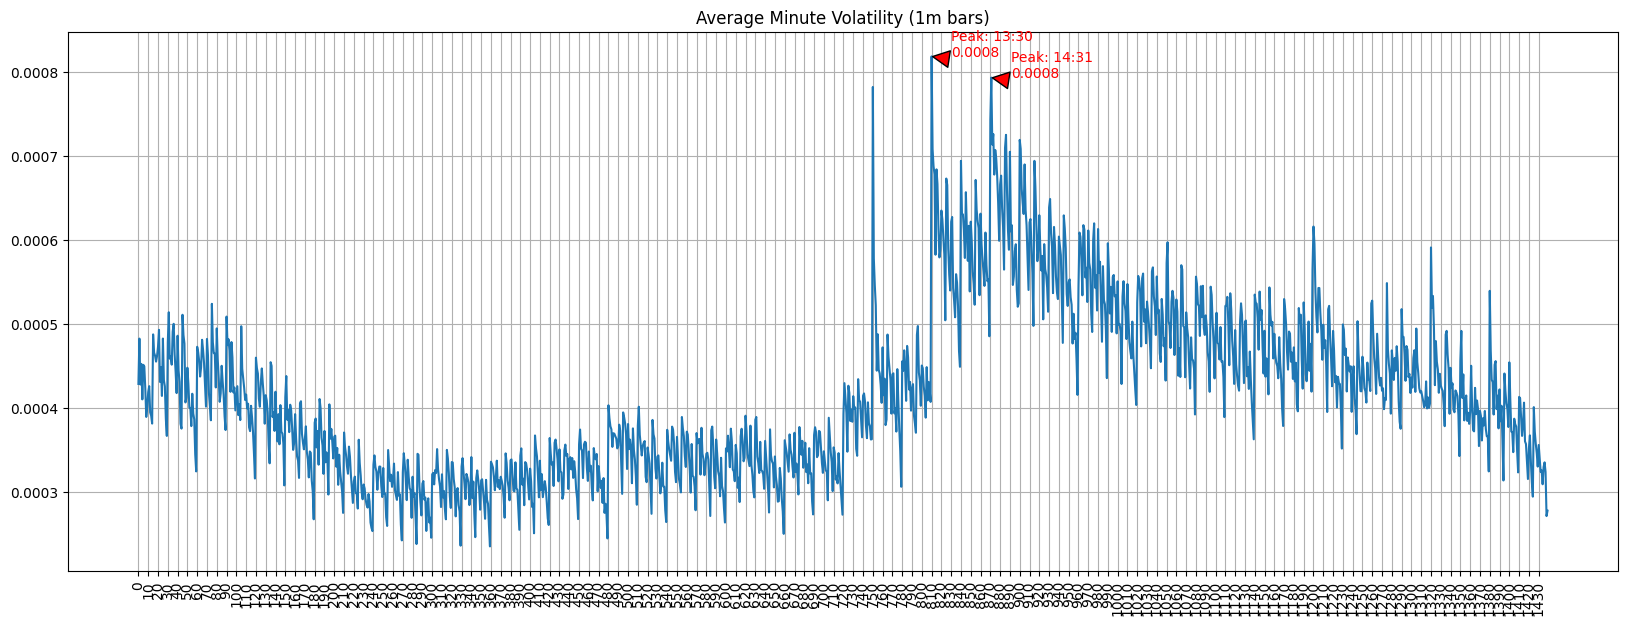

In [11]:
vol_arr_1m = [np.mean(abs(ret)) for hm, ret in rets1m.groupby(data1m['hour_minute'])]
import numpy as np
hour_minute_list = sorted(data1m['hour_minute'].unique())
top2_idx = np.argsort(vol_arr_1m)[-2:][::-1]  # indices of top 2 peaks, descending
plt.figure(figsize=(20, 7))
plt.plot(vol_arr_1m)
plt.xticks(range(0, 1440, 10), rotation=90)
plt.grid()
plt.title("Average Minute Volatility (1m bars)")
for idx in top2_idx:
    hm = hour_minute_list[idx]
    plt.annotate(f'Peak: {hm}\n{vol_arr_1m[idx]:.4f}', xy=(idx, vol_arr_1m[idx]), xytext=(idx+20, vol_arr_1m[idx]),
                 arrowprops=dict(facecolor='red', shrink=0.05), color='red')
plt.show()

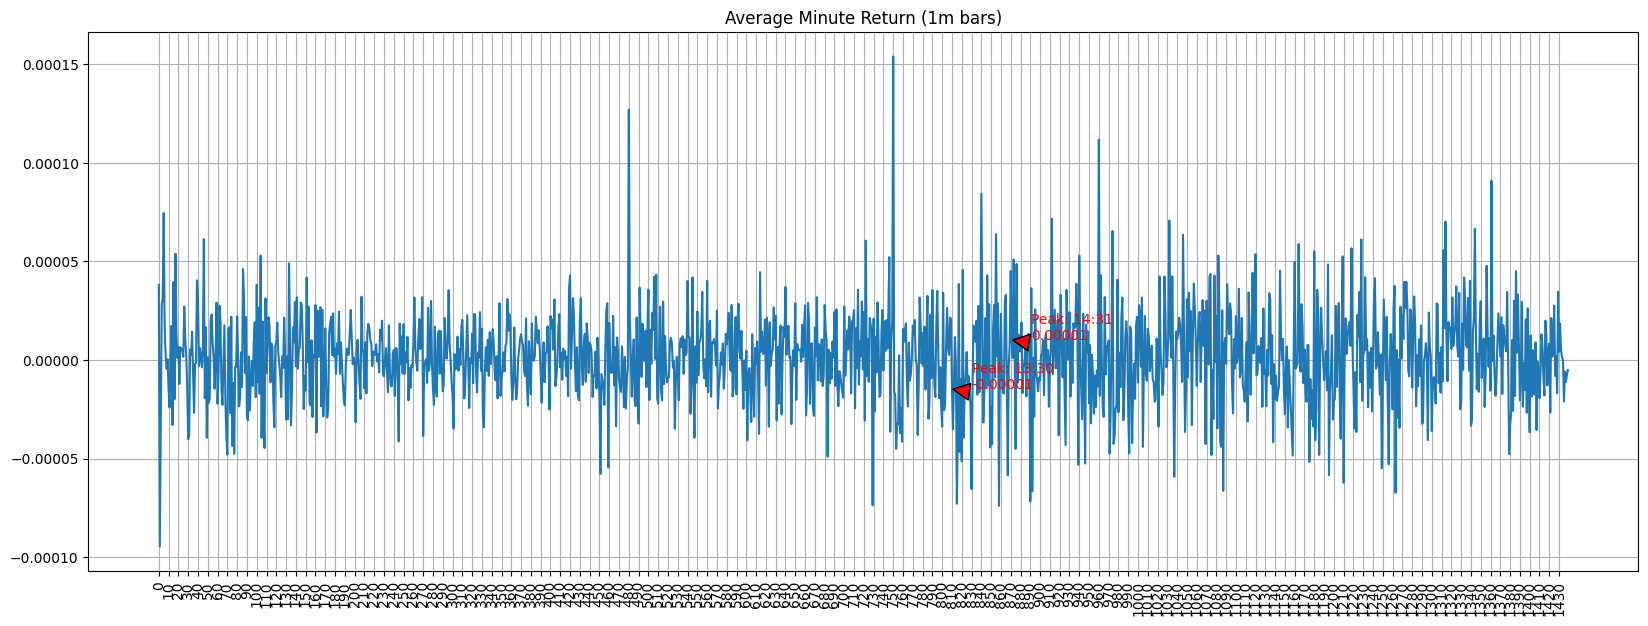

In [12]:
ret_arr_1m = [np.mean(ret) for hm, ret in rets1m.groupby(data1m['hour_minute'])]
plt.figure(figsize=(20, 7))
plt.plot(ret_arr_1m)
plt.xticks(range(0, 1440, 10), rotation=90)
plt.grid()
plt.title("Average Minute Return (1m bars)")
for idx in top2_idx:
    hm = hour_minute_list[idx]
    plt.annotate(f'Peak: {hm}\n{ret_arr_1m[idx]:.5f}', xy=(idx, ret_arr_1m[idx]), xytext=(idx+20, ret_arr_1m[idx]),
                 arrowprops=dict(facecolor='red', shrink=0.05), color='red')
plt.show()

In [13]:
data_1d = pd.read_parquet(r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020\ BTCUSDT-1d-data.parquet", columns=ohlcv_cols)
data_1d = data_1d[data_1d.index >= "2023-01-01"]
data_1d['rets'] = data_1d['close'].pct_change().dropna()
data_1d.dropna(inplace=True)
data_1d.head()  


,open,high,low,close,volume,rets
timestamp,,,,,,
2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,0.003353
2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,0.000072
2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,0.010494
2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,-0.001087
2023-01-06,16823.8,17030.0,16664.8,16943.8,316973.629,0.007133


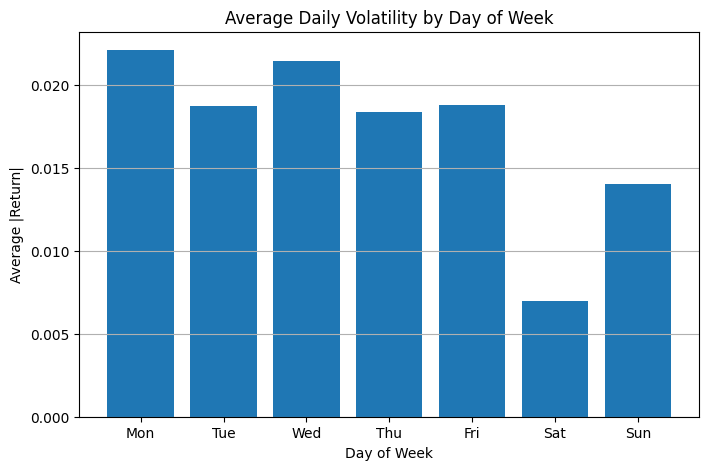

In [14]:
vol_arr_1d = [np.mean(abs(ret)) for dayofweek, ret in data_1d['rets'].groupby(data_1d.index.dayofweek)]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(8,5))
plt.bar(days, vol_arr_1d)
plt.title('Average Daily Volatility by Day of Week')
plt.ylabel('Average |Return|')
plt.xlabel('Day of Week')
plt.grid(axis='y')
plt.show()

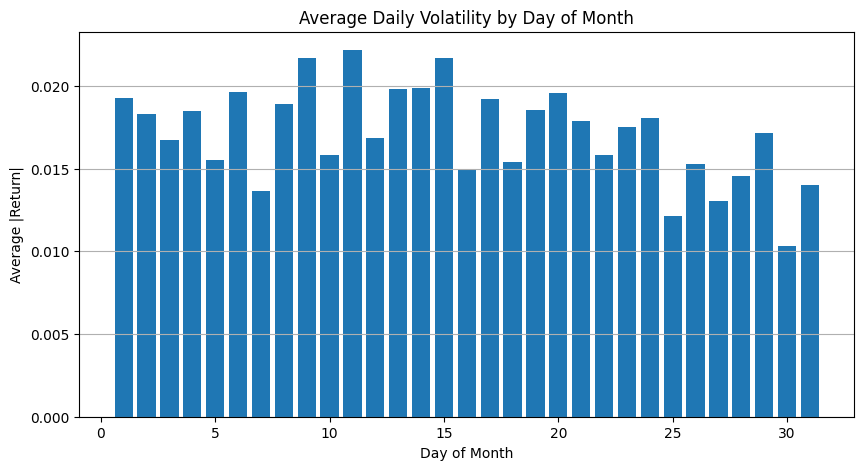

In [15]:
vol_arr_dayofmonth = [np.mean(abs(ret)) for day, ret in data_1d['rets'].groupby(data_1d.index.day)]
days_of_month = list(range(1, 32))
plt.figure(figsize=(10,5))
plt.bar(days_of_month, vol_arr_dayofmonth)
plt.title('Average Daily Volatility by Day of Month')
plt.ylabel('Average |Return|')
plt.xlabel('Day of Month')
plt.grid(axis='y')
plt.show()

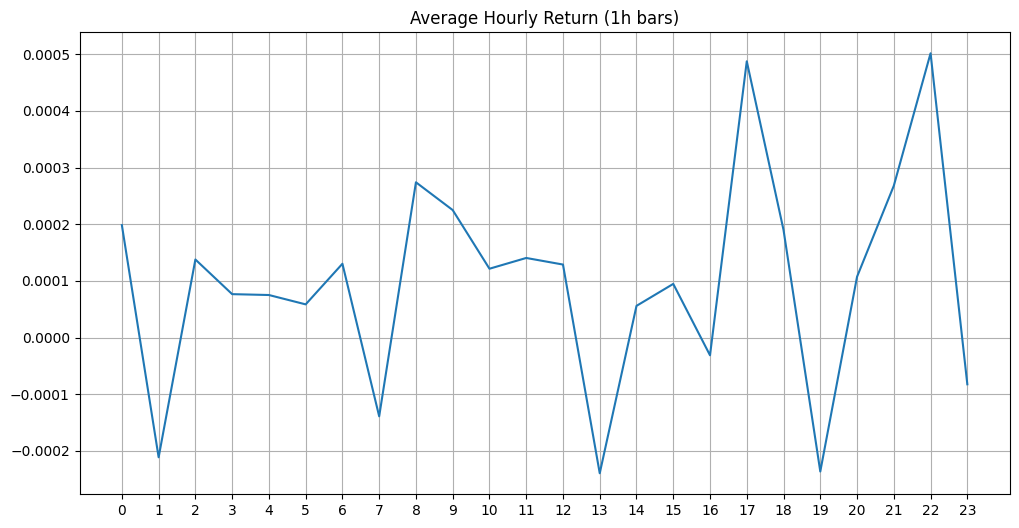

In [16]:
ret_arr = [np.mean(ret) for hour, ret in rets.groupby(rets.index.hour)]
plt.figure(figsize=(12, 6))
plt.plot(ret_arr)
plt.xticks(range(24))
plt.grid()
plt.title("Average Hourly Return (1h bars)")
plt.show()


In [17]:
ex_ret_1h = np.mean(ret_arr)
print(f"Average Hourly Return (1h bars): {ex_ret_1h:.5f}, Annualized: {(1+ex_ret_1h)**(24*365)-1:.2%}")


Average Hourly Return (1h bars): 0.00010, Annualized: 134.11%


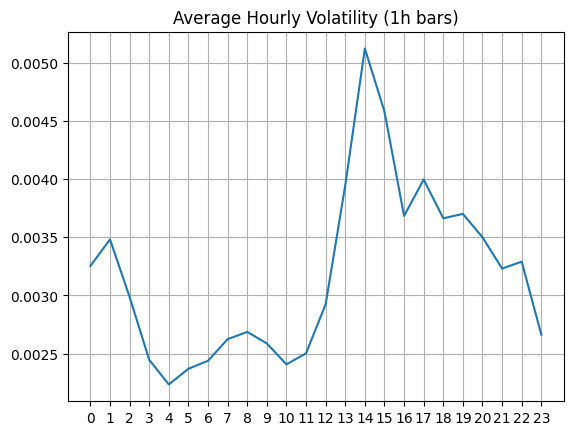

In [18]:
plt.plot(vol_arr)
plt.xticks(range(24))
plt.grid()
plt.title("Average Hourly Volatility (1h bars)")
plt.show()

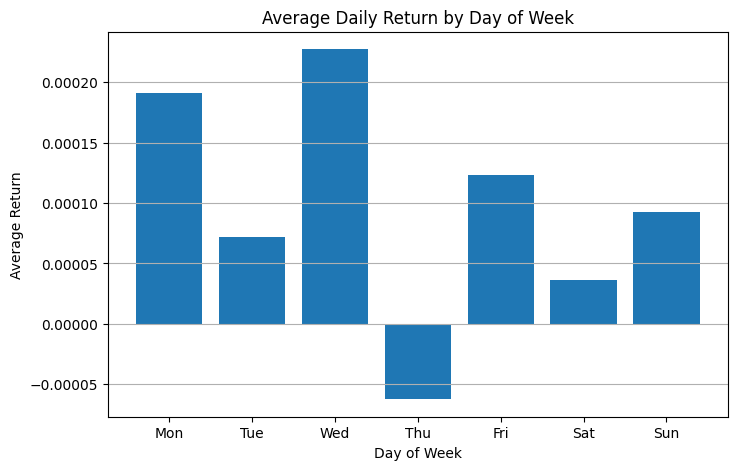

In [19]:
ret_arr_dayofweek = [np.mean(ret) for dayofweek, ret in rets.groupby(rets.index.dayofweek)]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(8,5))   
plt.bar(days, ret_arr_dayofweek)
plt.title('Average Daily Return by Day of Week')    
plt.ylabel('Average Return')
plt.xlabel('Day of Week')
plt.grid(axis='y')
plt.show()

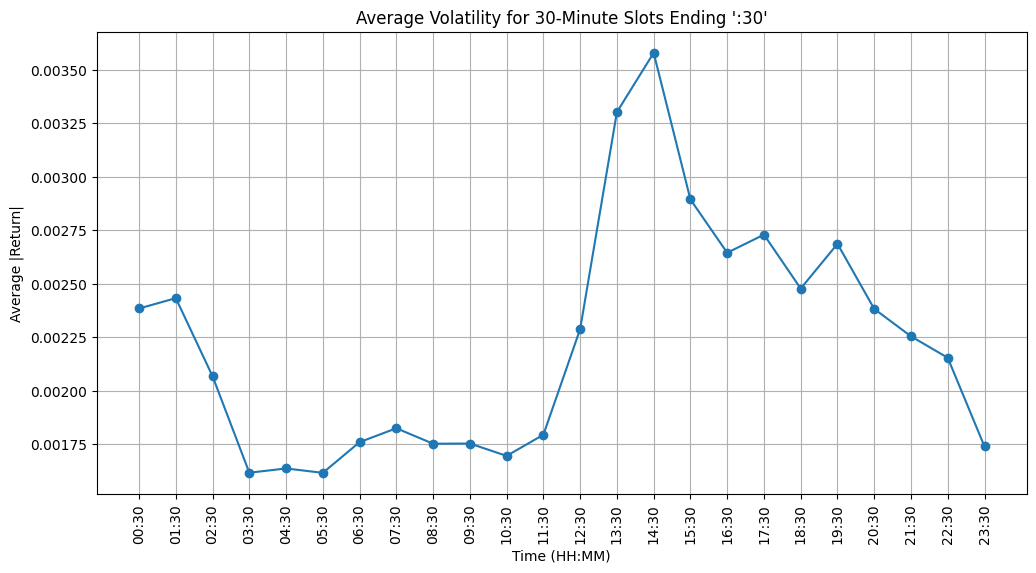

In [20]:
# Filter for half-hour slots ending in ':30'
mask_30 = data30min['half_hour'].str.endswith(':30')
vol_arr_30min_30 = [np.mean(abs(ret)) for hh, ret in rets30min[mask_30].groupby(data30min['half_hour'][mask_30])]
half_hour_30 = sorted(data30min['half_hour'][mask_30].unique())

plt.figure(figsize=(12,6))
plt.plot(half_hour_30, vol_arr_30min_30, marker='o')
plt.xticks(rotation=90)
plt.grid()
plt.title("Average Volatility for 30-Minute Slots Ending ':30'")
plt.xlabel("Time (HH:MM)")
plt.ylabel("Average |Return|")
plt.show()

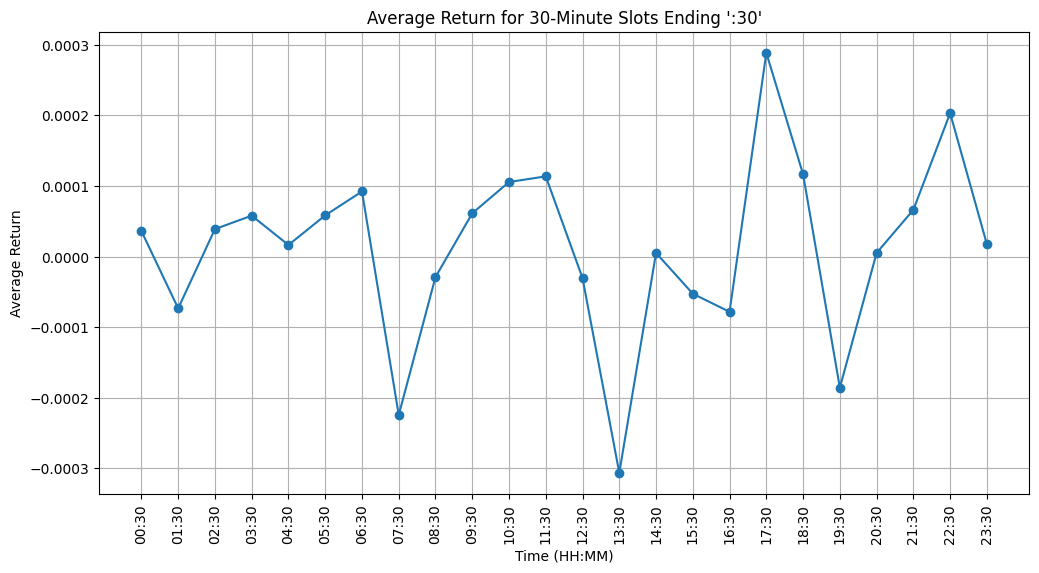

In [21]:
# Filter for half-hour slots ending in ':30'
mask_30 = data30min['half_hour'].str.endswith(':30')
data30min_30 = data30min[mask_30].copy()
rets30min_30 = data30min_30['close'].pct_change().dropna()
ret_arr_30min_30 = [np.mean(ret) for hh, ret in rets30min[mask_30].groupby(data30min['half_hour'][mask_30])]
half_hour_30 = sorted(data30min['half_hour'][mask_30].unique())

plt.figure(figsize=(12,6))
plt.plot(half_hour_30, ret_arr_30min_30, marker='o')
plt.xticks(rotation=90)
plt.grid()
plt.title("Average Return for 30-Minute Slots Ending ':30'")
plt.xlabel("Time (HH:MM)")
plt.ylabel("Average Return")
plt.show()